In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
import src.beam_functions as BF

In [2]:
lmod_4_a00=np.load("lmod_4_a00.npy")
lmod_lmax_a00=np.load("lmod_lmax_a00.npy")

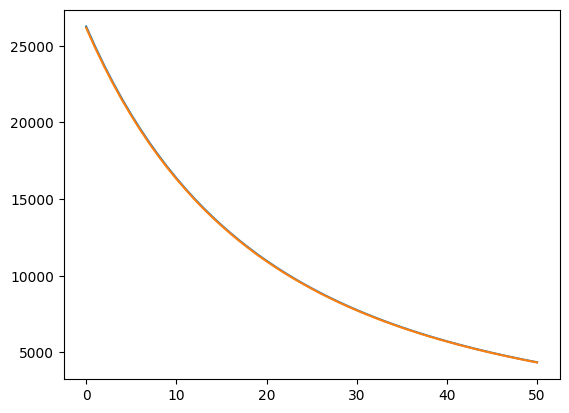

In [16]:
plt.plot(lmod_4_a00)
plt.plot(lmod_lmax_a00)

/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_18222/2467986521.py:1: RuntimeWarning: overflow encountered in exp
  f = lambda x, A, alpha, b: A*1e3*x**(-alpha)*np.exp(b*np.log(x)**2)


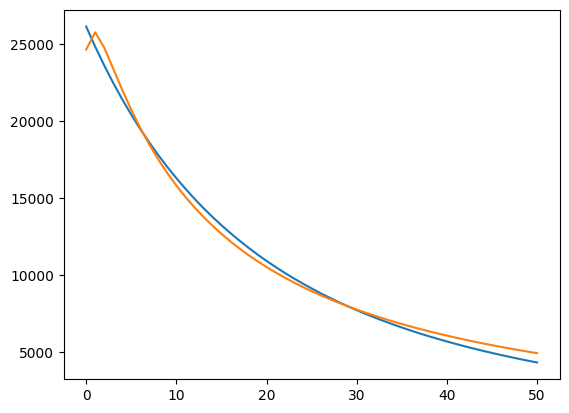

In [20]:
f = lambda x, A, alpha, b: A*1e3*x**(-alpha)*np.exp(b*np.log(x)**2)
xx = np.array(list(range(1, 52)))
res_4 = curve_fit(f, xx, lmod_4_a00)
res_lmax = curve_fit(f, xx, lmod_lmax_a00, p0=[10, 2.5, 0.01])

plt.plot(lmod_lmax_a00)
plt.plot(f(xx,*res_lmax[0]))


In [42]:
import src.forward_model as FM
from src.blockmat import BlockMatrix
reload(FM)

<module 'src.forward_model' from '/Users/yordani/Documents/boosted_compass/matrix-observer/src/forward_model.py'>

In [43]:
def fg_polymod(nuarr, *theta_fg):
    Afg, alpha = theta_fg[:2]
    zetas      = theta_fg[2:]
    exponent = [zetas[i]*np.log(nuarr/60)**(i+2) for i in range(len(zetas))]
    fg_a00_terms = (Afg*1e3)*(nuarr/60)**(-alpha) * np.exp(np.sum(exponent, 0))
    return fg_a00_terms

In [48]:
nuarr = np.linspace(50, 100, 51)
Nfreq = len(nuarr)
Nbin  = 2
Nlmod = 3
A_dummy = np.zeros((Nfreq, Nbin, Nlmod))
A_dummy = BlockMatrix(mat=A_dummy)
mod = FM.generate_binwise_forward_model(nuarr, A_dummy, Npoly=4)

In [56]:
theta_test       = [10, 2.5, .001, -.001]
theta_test_extra = [9 , 2.1, -.001, .001]
theta_mod  = np.array(theta_test+theta_test_extra, dtype=np.float128)
theta_test       = np.array(theta_test)
theta_test_extra = np.array(theta_test_extra)

theta_mod[0] = np.log(theta_mod[0]*1e3)
theta_mod[1] = -theta_mod[1]
theta_mod[4] = np.log(theta_mod[4]*1e3)
theta_mod[5] = -theta_mod[5]

d_test       = fg_polymod(nuarr, *theta_test)
d_test_extra = fg_polymod(nuarr, *theta_test_extra)
d_mod = mod(theta_mod)


In [57]:
d_mod.shape

(102,)

In [60]:
theta_mod

array([ 9.21034037e+00, -2.50000000e+00,  1.00000000e-03, -1.00000000e-03,
        9.10497986e+00, -2.10000000e+00, -1.00000000e-03,  1.00000000e-03],
      dtype=float128)

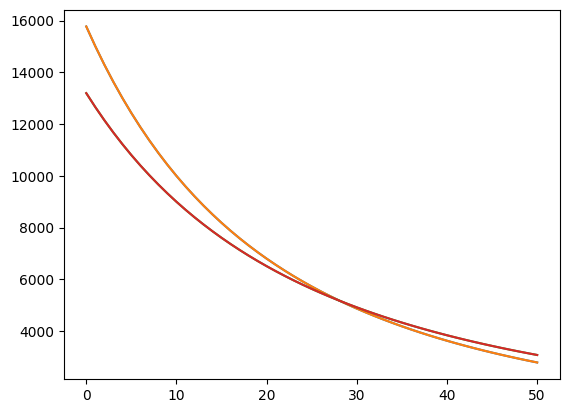

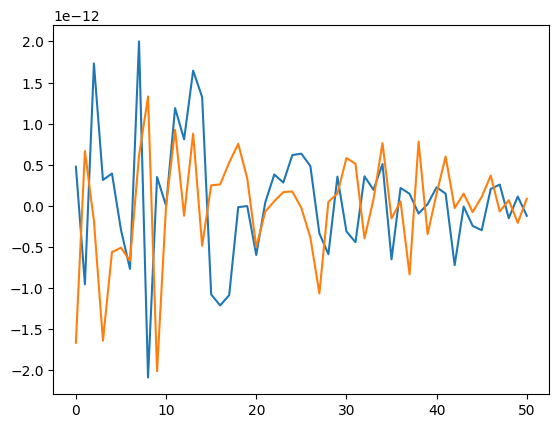

In [58]:
plt.plot(d_test)
plt.plot(np.split(d_mod, 2)[0])
plt.plot(d_test_extra)
plt.plot(np.split(d_mod, 2)[1])
plt.show()
plt.plot(d_test-np.split(d_mod, 2)[0])
plt.plot(d_test_extra-np.split(d_mod, 2)[1])
plt.show()

In [25]:
theta_test       = [10, 2.5, .001, -.001]
theta_test_extra = [9, 2.1, -.001, .001]


theta_mod  = np.array(theta_test+theta_test_extra, dtype=np.float128)
theta_test       = np.array(theta_test, dtype=np.float128)
theta_test_extra = np.array(theta_test_extra, dtype=np.float128)
theta_mod[0] = np.log(theta_mod[0]*1e3)
theta_mod[1] = -theta_mod[1]
theta_mod[4] = np.log(theta_mod[4]*1e3)
theta_mod[5] = -theta_mod[5]

d_test       = fg_polymod(nuarr, *theta_test)
d_test_extra = fg_polymod(nuarr, *theta_test_extra)
d_mod = mod(theta_mod)


array([ 9.0e+00,  2.1e+00, -1.0e-03,  1.0e-03], dtype=float128)

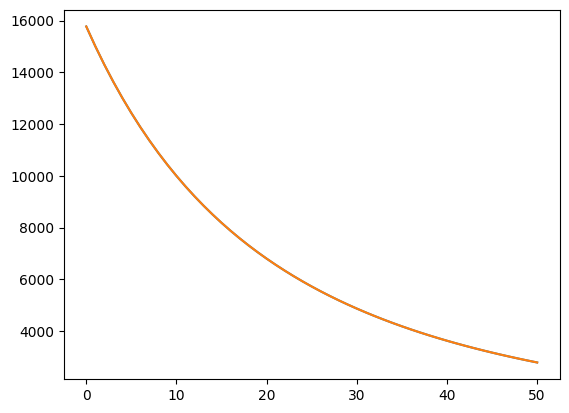

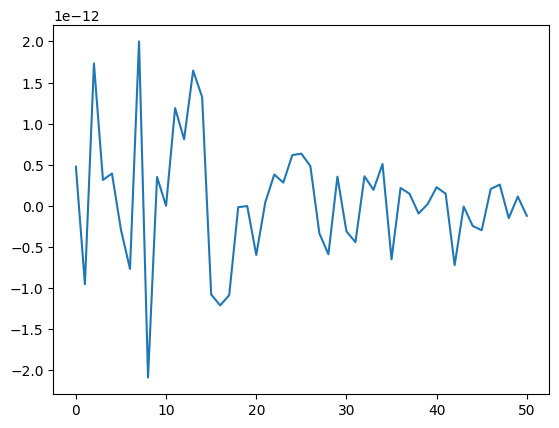

In [47]:
plt.plot(d_test)
plt.plot(d_mod)
plt.show()
plt.plot(d_test-d_mod)
plt.show()

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


Text(0, 0.5, '|blm|')

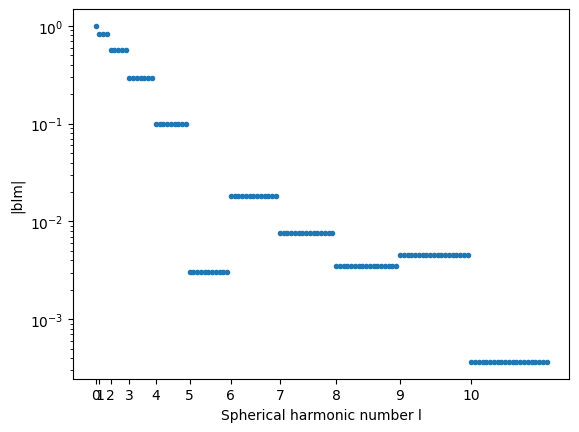

In [44]:
import src.spherical_harmonics as SH
RS = SH.RealSphericalHarmonics()
nside=32
lmax=10
narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)
blm = BF.calc_beam_vector(nside=nside, lmax=lmax, beam_use=narrow_cosbeam)
lmax_arr = list(range(0, lmax+1, 1))
lmax_idx = [RS.get_idx(l=l, m=-l) for l in lmax_arr]
_=plt.xticks(ticks=lmax_idx, labels=lmax_arr)
plt.semilogy(abs(blm), '.')
plt.xlabel("Spherical harmonic number l")
plt.ylabel("|blm|")



In [45]:
import src.sky_models as SM
alm = SM.foreground_gsma_alm_nsidelo(nu=60, lmax=lmax, nside=nside, use_mat_Y=True)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 66


Text(0, 0.5, 'GSMA |alm| [60MHz]')

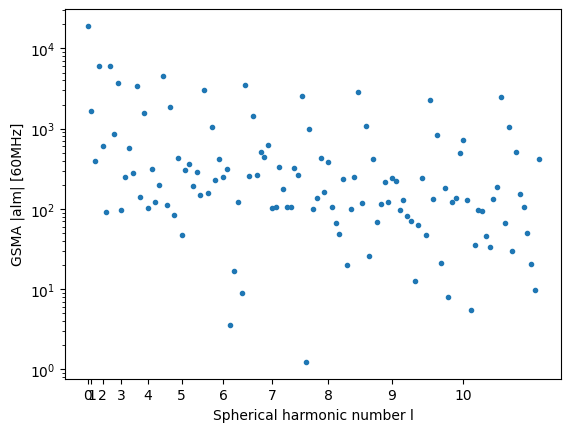

In [46]:
_=plt.xticks(ticks=lmax_idx, labels=lmax_arr)
plt.semilogy(abs(alm), '.')
plt.xlabel("Spherical harmonic number l")
plt.ylabel("GSMA |alm| [60MHz]")

Text(0, 0.5, 'GSMA |alm x blm| [60MHz]')

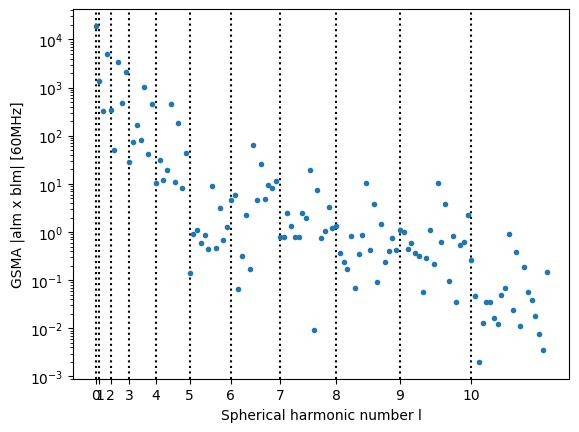

In [47]:
_=plt.xticks(ticks=lmax_idx, labels=lmax_arr)
for ell in lmax_idx:
    plt.axvline(ell, linestyle=':', color='k')
plt.semilogy(abs(alm)*abs(blm), '.')
plt.xlabel("Spherical harmonic number l")
plt.ylabel("GSMA |alm x blm| [60MHz]")

In [4]:
from src.beam_functions import beam_cos_FWHM

In [5]:
import src.beam_functions as BF

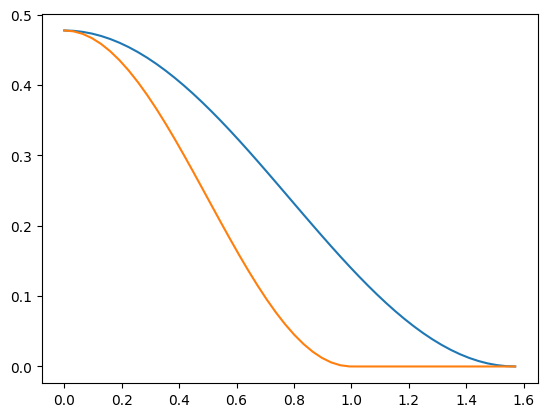

In [6]:
xx=np.linspace(0,np.pi/2)
yy = [beam_cos_FWHM(x,np.pi/2) for x in xx]
yy1 = [beam_cos_FWHM(x,1) for x in xx]
plt.plot(xx, yy)
plt.plot(xx, yy1)

Text(0, 0.5, 'FWHM [degrees]')

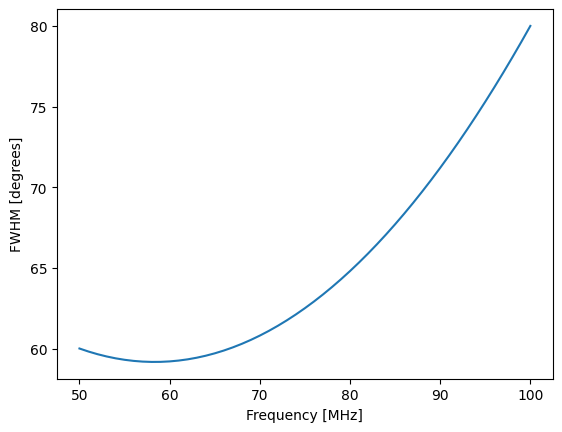

In [7]:
nuarr=np.linspace(50,100,51)
plt.plot(nuarr,np.degrees(BF.fwhm_func_tauscher(nu=nuarr)))
plt.xlabel("Frequency [MHz]")
plt.ylabel("FWHM [degrees]")

In [10]:
def beam(theta, nu):
    return beam_cos_FWHM(theta, BF.fwhm_func_tauscher(nu=nu, c=.024, fwhm_hi=73, fwhm_lo=73))


Text(0, 0.5, 'beam shape (non-normalised)')

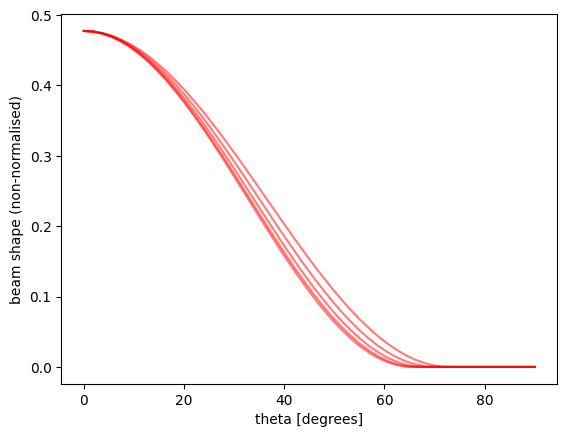

In [11]:
nuarr_smol = np.linspace(50,100, 10)
beam_samples = [[beam(theta, nu) for theta in xx] for nu in nuarr_smol]
alphas = [(nu/100)**2 for nu in nuarr]
for beam_shape, alpha in zip(beam_samples, alphas):
    plt.plot(np.degrees(xx), beam_shape, color='r', alpha=alpha)
plt.xlabel("theta [degrees]")
plt.ylabel("beam shape (non-normalised)")

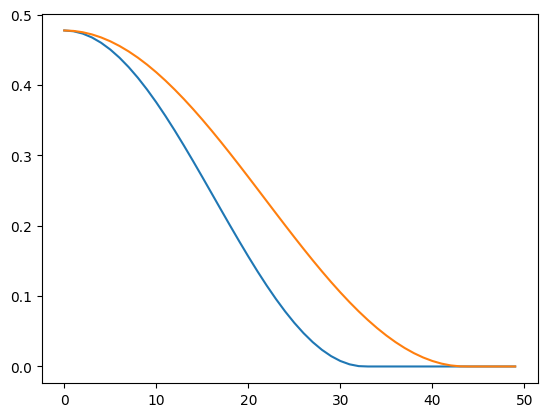

In [24]:
plt.plot(beam_samples[0])
plt.plot(beam_samples[-1])

In [13]:

mats_fid = np.load("saves/mats_fid.npy", allow_pickle=True)

In [51]:
import src.map_making as MM
reload(MM)

<module 'src.map_making' from '/Users/yordani/Documents/boosted_compass/matrix-observer/src/map_making.py'>

In [3]:
gammas = [-x-1 for x in range(5)]
ones = [1 for _ in range(4)]
print(np.diag(gammas, k=0))
print(np.diag(ones, k=1))

[[-1  0  0  0  0]
 [ 0 -2  0  0  0]
 [ 0  0 -3  0  0]
 [ 0  0  0 -4  0]
 [ 0  0  0  0 -5]]
[[0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 0]]


In [4]:
print(np.c_[np.diag(gammas, k=0)+np.diag(ones, k=1), np.array([0,0,0,0,1])])

[[-1  1  0  0  0  0]
 [ 0 -2  1  0  0  0]
 [ 0  0 -3  1  0  0]
 [ 0  0  0 -4  1  0]
 [ 0  0  0  0 -5  1]]


In [16]:
MM.calc_reg_matrix_exp(2, np.linspace(50,100,3))

array([[-0.95      ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        , -0.96666667,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , -0.95      ,  1.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.96666667,
         1.        ]])

In [48]:
a = ['00_0', '1-1_0', '10_0', '11_0', '00_1', '1-1_1', '10_1', '11_1', '00_2', '1-1_2', '10_2', '11_2']
b=MM.sort_alm_vector_frequency(a, Nfreq=3, Nlmod=4)
list(b)

['00_0',
 '00_1',
 '00_2',
 '1-1_0',
 '1-1_1',
 '1-1_2',
 '10_0',
 '10_1',
 '10_2',
 '11_0',
 '11_1',
 '11_2']

In [49]:
MM.sort_alm_vector_lm(list(b), Nfreq=3, Nlmod=4)

array(['00_0', '1-1_0', '10_0', '11_0', '00_1', '1-1_1', '10_1', '11_1',
       '00_2', '1-1_2', '10_2', '11_2'], dtype='<U5')

In [52]:
a = ['10','20','11','21','12','22','13','23','14','24','15','25',]
b=MM.sort_alm_vector_frequency(a, Nfreq=6, Nlmod=2)
list(b)

['10', '11', '12', '13', '14', '15', '20', '21', '22', '23', '24', '25']

In [53]:
MM.sort_alm_vector_lm(list(b), Nfreq=6, Nlmod=2)

array(['10', '20', '11', '21', '12', '22', '13', '23', '14', '24', '15',
       '25'], dtype='<U2')